In [1]:
from fredapi import Fred
# import plotly.graph_objects as go #used for data visualization
import pandas as pd
from statsmodels.tsa.api import VAR

# we can import data from fred in case we need to
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')

# Data

* oil, bonds: FRED
* gold: CSV file

In [2]:
# read in data from csv
bond_data_10y = pd.DataFrame(fred.get_series('DGS10')).reset_index()

# rename columns to date and real_bond
bond_data_10y.columns = ['date', 'bond']

gold_data = pd.read_csv('gold.csv')
gold_data.columns = ['date', 'gold']

oil_data_US = pd.DataFrame(fred.get_series('DCOILWTICO')).reset_index()
oil_data_EU = pd.DataFrame(fred.get_series('DCOILBRENTEU')).reset_index()

oil_data_US.columns = ['date', 'oil']
oil_data_EU.columns = ['date', 'oil_EU']

oil_data = oil_data_US

<Axes: >

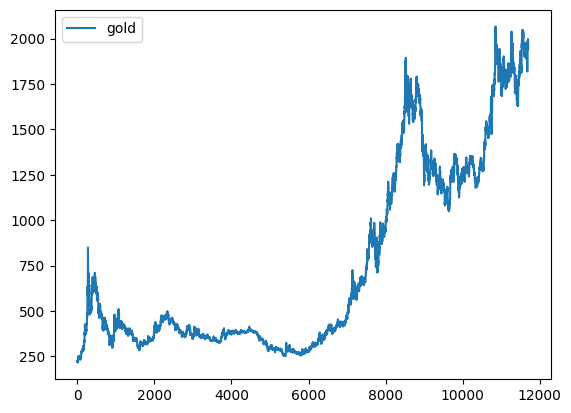

In [3]:
gold_data.plot()

In [4]:
# Convert 'date' column to datetime format for consistency
oil_data['date'] = pd.to_datetime(oil_data['date'])
gold_data['date'] = pd.to_datetime(gold_data['date'])
bond_data_10y['date'] = pd.to_datetime(bond_data_10y['date'])

# Merge datasets on the 'date' column with left merge
merged_data = pd.merge(bond_data_10y, oil_data, on='date', how='left')
merged_data = pd.merge(merged_data, gold_data, on='date', how='left')

# Forward fill missing values
merged_data = merged_data.ffill()

# drop NaN values
merged_data = merged_data.dropna()

df = merged_data

In [5]:
# cut off data at 2023-11-10
df = df[df['date'] < '2023-11-10']

# drop dates before 2008
df = df[df['date'] >= '2008-01-01']

# Stationarity

## visual inspection

<Axes: title={'center': 'bond Prices'}, xlabel='date'>

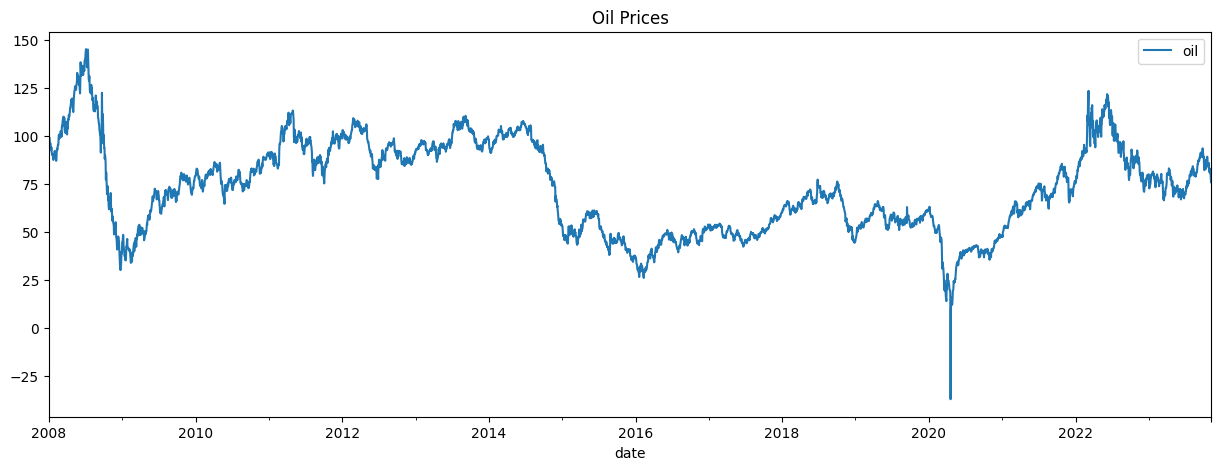

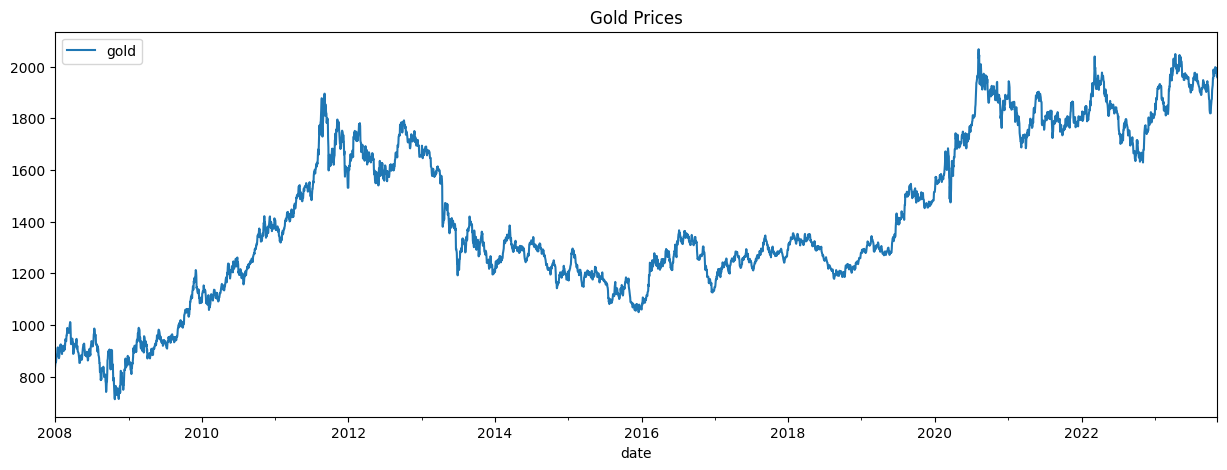

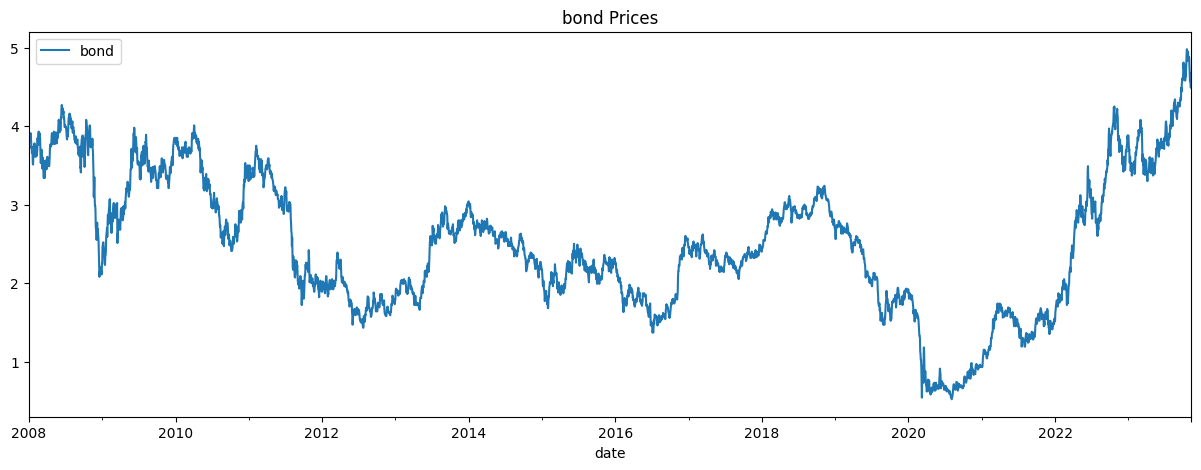

In [6]:
df[['date', 'oil']].plot(x='date', figsize=(15, 5), title='Oil Prices')
df[['date', 'gold']].plot(x='date', figsize=(15, 5), title='Gold Prices')
df[['date', 'bond']].plot(x='date', figsize=(15, 5), title='bond Prices')

* From a visual inspection, it seems like none of the variables are stationary.

## ADF test (Unit root test)

In [7]:
from statsmodels.tsa.stattools import adfuller, coint


def adf_test(df, x=""):
    print(f"{x} adf test")
    result = adfuller(df[x])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    if result[1] < 0.05:
        print('Data is likely Stationary\n')
    else:
        print('Data is likely Non-Stationary\n')

In [8]:
adf_test(df, 'oil')
adf_test(df, 'gold')
adf_test(df, 'bond')

oil adf test
ADF Statistic: -2.839360
p-value: 0.052868
Data is likely Non-Stationary

gold adf test
ADF Statistic: -1.235764
p-value: 0.658025
Data is likely Non-Stationary

bond adf test
ADF Statistic: -1.714253
p-value: 0.423784
Data is likely Non-Stationary



In [9]:
# returns for each variable
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# convert oil and gold to returns
df['oil_ret'] = df['oil'].pct_change()
df['gold_ret'] = df['gold'].pct_change()
df['bond_ret'] = df['bond'].pct_change()

df = df.dropna()

adf_test(df, 'oil_ret')
adf_test(df, 'gold_ret')
adf_test(df, 'bond_ret')

oil_ret adf test
ADF Statistic: -11.862321
p-value: 0.000000
Data is likely Stationary

gold_ret adf test
ADF Statistic: -12.857253
p-value: 0.000000
Data is likely Stationary

bond_ret adf test
ADF Statistic: -13.201905
p-value: 0.000000
Data is likely Stationary



* none of the series are stationary
* we can check for cointegration between the series
* we may need to do the TY method

# trash

### 2) Set VAR to levels (same as VAR with no diff)

In [10]:
dff = df[['oil', 'gold', 'bond']]
model = VAR(dff)
results = model.fit()
# results = model.fit(maxlags=20, ic='aic')

## Forecasting

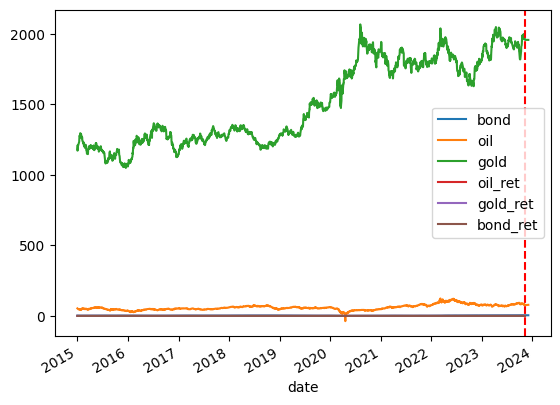

In [11]:
# get the lag_order
lag_order = results.k_ar

# Forecasting (assuming 'steps' is the number of steps you want to forecast)
steps = 24
forecast = results.forecast(dff.values[-lag_order:], steps=steps)

# make forecast into a df
# Assuming 'forecast' is a NumPy array or pandas Series
forecast_df = pd.DataFrame(forecast, columns=['oil', 'gold', 'bond'])

# get the last date in df
last_date = df['date'].iloc[-1]

# create step more dates in df with the corresponding dates
date_range = pd.date_range(last_date, periods=steps+1, freq='D')[1:]

# add the dates to the reversed_forecast
forecast_df['date'] = date_range

# add the dates to the reversed_forecast
forecast_df['date'] = date_range

# concat the df and the reversed_forecast
forecast_df = pd.concat([df, forecast_df], ignore_index=True)

# drop dates
forecast_df = forecast_df[forecast_df['date'] >= '2015-01-01']
forecast_df.plot(x='date')

# add a line at 11/1/2020
import matplotlib.pyplot as plt
plt.axvline(x=df['date'].max(), color='r', linestyle='--')

In [12]:
forecast_df

,date,bond,oil,gold,oil_ret,gold_ret,bond_ret
1826,2015-01-01,2.170000,53.450000,1206.000000,0.000000,0.000000,0.000000
1827,2015-01-02,2.120000,52.720000,1172.000000,-0.013658,-0.028192,-0.023041
1828,2015-01-05,2.040000,50.050000,1200.000000,-0.050645,0.023891,-0.037736
1829,2015-01-06,1.970000,47.980000,1210.250000,-0.041359,0.008542,-0.034314
1830,2015-01-07,1.960000,48.690000,1210.500000,0.014798,0.000207,-0.005076
...,...,...,...,...,...,...,...
4156,2023-11-29,4.572015,78.202738,1957.347142,NaN,NaN,NaN
4157,2023-11-30,4.569725,78.291013,1957.323046,NaN,NaN,NaN
4158,2023-12-01,4.567445,78.378841,1957.297222,NaN,NaN,NaN
4159,2023-12-02,4.565175,78.466222,1957.269681,NaN,NaN,NaN


Figure(1000x1000)


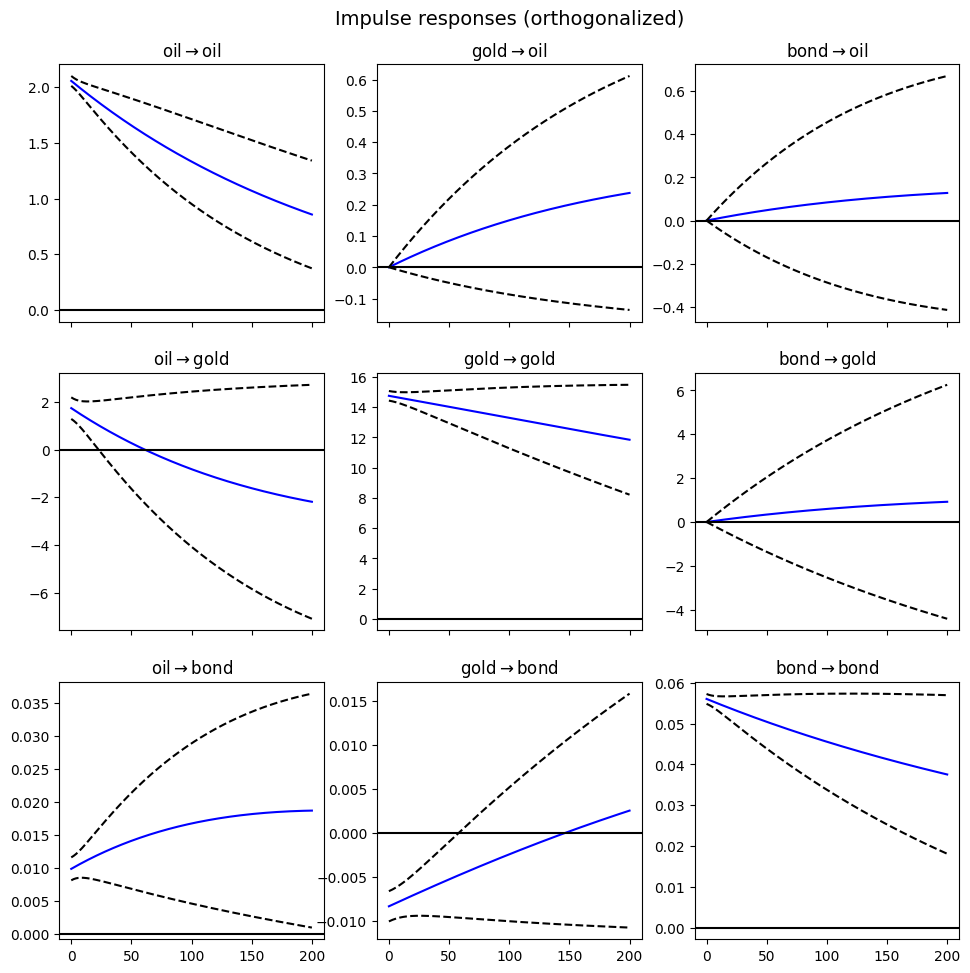

In [13]:
irf = results.irf(200)
print(irf.plot(orth=True))

In [14]:
test = results.test_causality('bond', ['gold', 'oil'], kind='f')
print(test.summary())

Granger causality F-test. H_0: ['gold', 'oil'] do not Granger-cause bond. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.835          2.996   0.160 (2, 12396)
------------------------------------------------


# Forecasting using VAR method with I(1) data

In [15]:
from statsmodels.tsa.api import VAR

# Assuming 'df' is your original time series dataframe
df_diff = df[['bond_ret', 'oil_ret', 'gold_ret' ]]

model = VAR(df_diff)
results = model.fit(maxlags=20, ic='aic')

# get the lag_order
lag_order = results.k_ar

# Forecasting (assuming 'steps' is the number of steps you want to forecast)
steps = 365
forecast = results.forecast(df_diff.values[-lag_order:], steps=steps)

# Reverse differencing to obtain forecasts in the original scale
reversed_forecast_diff = pd.DataFrame(forecast, columns=['oil', 'gold', 'bond'])

# Cumulatively sum the forecasted differenced values
reversed_forecast = reversed_forecast_diff.cumsum() + df[['oil', 'gold', 'bond']].iloc[-1]

In [16]:
lag_order = results.k_ar
print(lag_order)

print(results.summary())

20
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Nov, 2023
Time:                     08:56:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -21.8165
Nobs:                     4117.00    HQIC:                  -21.9980
Log likelihood:           28145.4    FPE:                2.53033e-10
AIC:                     -22.0975    Det(Omega_mle):     2.42111e-10
--------------------------------------------------------------------
Results for equation bond_ret
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000510         0.000430            1.187           0.235
L1.bond_ret         -0.021652         0.015920           -1.360           0.174
L1.oil_ret           0.015807         0.007862            

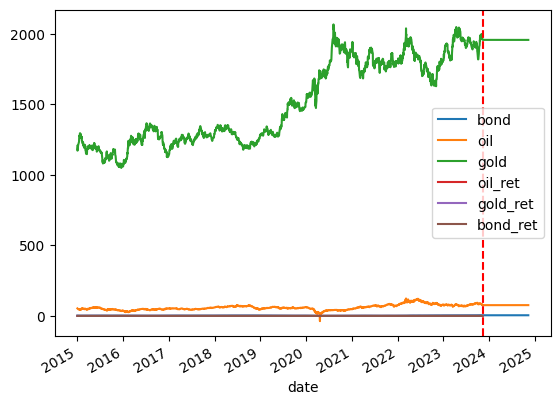

In [17]:
# get the last date in df
last_date = df['date'].iloc[-1]

# create step more dates in df with the corresponding dates
date_range = pd.date_range(last_date, periods=steps+1, freq='D')[1:]

# add the dates to the reversed_forecast
reversed_forecast['date'] = date_range

# concat the df and reversed_forecast
df_forecast = pd.concat([df, reversed_forecast], ignore_index=True)

# drop dates
df_forecast = df_forecast[df_forecast['date'] >= '2015-01-01']
df_forecast.plot(x='date')

# add a line at 11/1/2020
import matplotlib.pyplot as plt
plt.axvline(x=df['date'].max(), color='r', linestyle='--')


## Impulse response function

Figure(1000x1000)


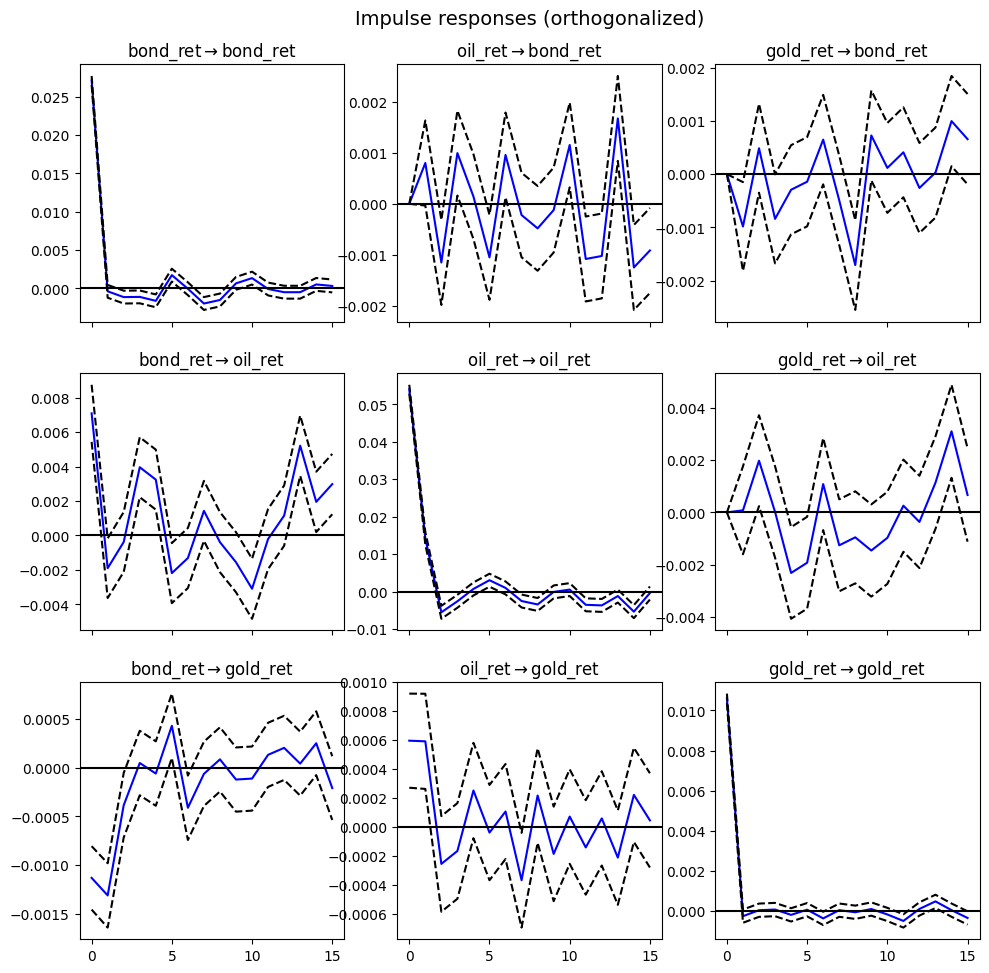

In [18]:
irf = results.irf(15)
print(irf.plot(orth=True))

## Granger Causality

In [20]:
# test1 = results.test_causality('bond', ['gold', 'oil'], kind='f')
# test2 = results.test_causality(['gold', 'oil'], 'bond' , kind='f')
# test3 = results.test_causality(['oil'], 'bond' , kind='f')

# print(test1.summary())
# print(test2.summary())
# print(test3.summary())

# # omitted variable bias if we do not include oil and gold even if they dont granger cause 10y bonds

# ARIMA

In [21]:
# take diff
df_diff = df[['oil', 'gold', 'bond']].diff().dropna()

plot_pacf(df_diff['oil'], lags=20)
plot_acf(df_diff['oil'], lags=20)

# plot_pacf(df_diff['gold'], lags=20)
# plot_acf(df_diff['gold'], lags=20)

# plot_pacf(df_diff['bond'], lags=20)
# plot_acf(df_diff['bond'], lags=20)

NameError: name 'plot_pacf' is not defined

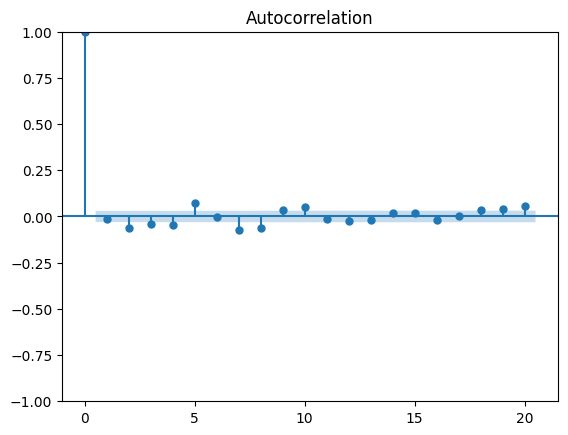

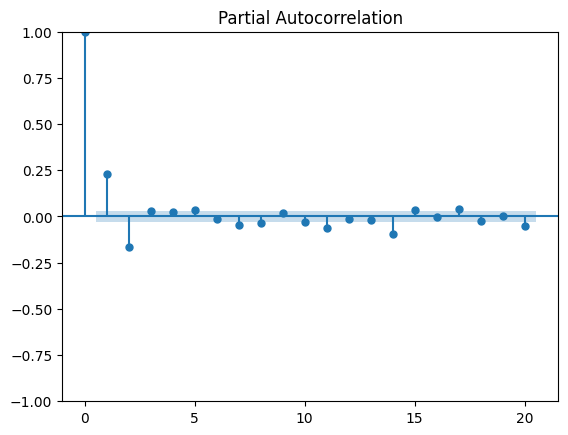

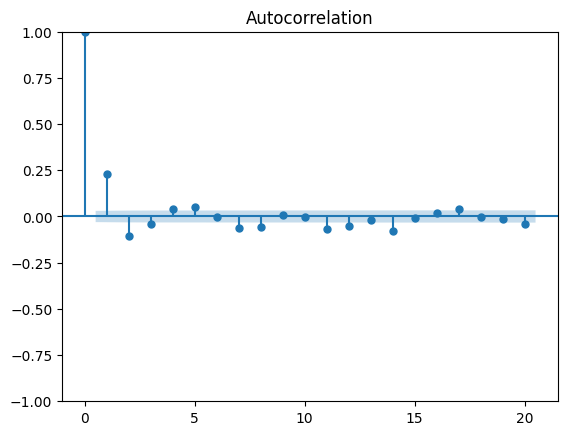

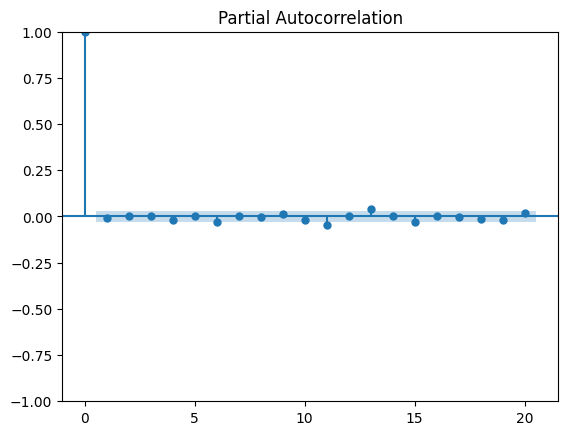

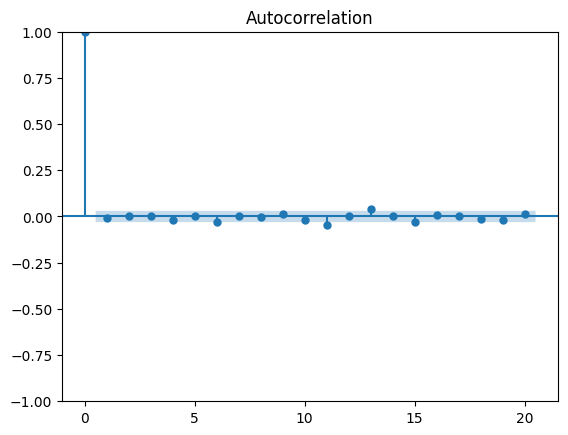

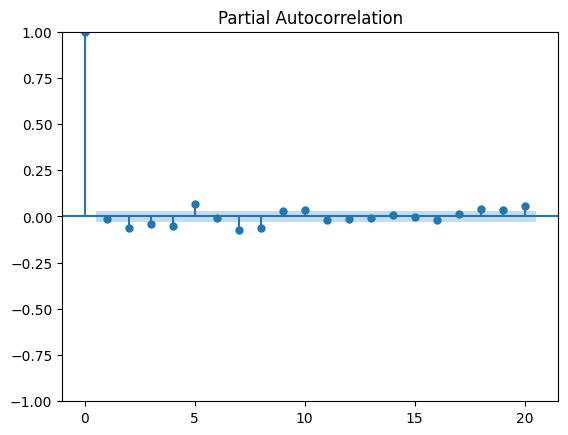

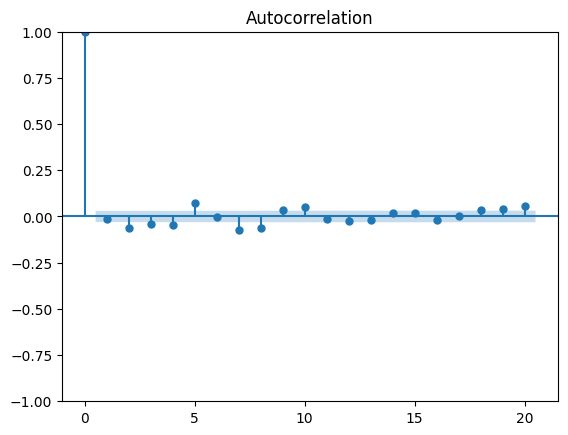

In [22]:
# Plot pacf and acf for oil, gold, and bonds
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(df['oil_ret'], lags=20)
plot_acf(df['oil_ret'], lags=20)

plot_pacf(df['gold_ret'], lags=20)
plot_acf(df['gold_ret'], lags=20)

plot_pacf(df['bond_ret'], lags=20)
plot_acf(df['bond_ret'], lags=20)

In [23]:
# # import arima from statsmodels
# from statsmodels.tsa.arima.model import ARIMA

# # for i in range(3):
# #     for k in range(3):
# #         print(i, 0, k, '\n')
# #         # fit the model using arima
# #         model = ARIMA(df['bond_ret'], order=(i, 0, k))
# #         results = model.fit()
# #         print(results.summary())


# # fit the model using arima
# model = ARIMA(df['bond_ret'], order=(1, 0, 1))
# results = model.fit()
# print(results.summary())


# # get predictions 
# preds = results.predict(start=0, end=len(df['bond_ret'])+24)

# pred
# # # plot predictions
# # df['pred'] = preds

# # df[['date', 'pred']].plot(x='date', figsize=(15, 5), title='bond Prices')

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['bond_ret'], order=(1, 0, 1))  # Assuming you've identified (p, d, q) as (1, 0, 1)
results = model.fit()

# Get predictions for the next 10 days (assuming daily data)
forecast_steps = 10
preds = results.forecast(steps=forecast_steps)

print("Predictions for the next 10 days:")
print(preds)

Predictions for the next 10 days:
4137    0.001016
4138    0.000892
4139    0.000794
4140    0.000716
4141    0.000654
4142    0.000605
4143    0.000566
4144    0.000535
4145    0.000510
4146    0.000490
Name: predicted_mean, dtype: float64


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'bond_ret' is a time series column in your DataFrame 'df'
X = df['bond_ret'].values

# Splitting the data - assuming you want to forecast the last 20% of the data
split_index = int(len(X) * 0.8)  # Splitting at 80-20 train-test ratio

X_train, X_test = X[:split_index], X[split_index:]

# Fit the ARIMA model on the training data
model = ARIMA(X_train, order=(1, 0, 1))  # Adjust order as needed
results = model.fit()

# Get predictions for the test set (last 20% of data)
forecast_steps = len(X) - split_index  # Forecasting the remaining portion
preds = results.forecast(steps=forecast_steps)

# Print or analyze predictions for the test set
print("Predictions for the test set:")
print(preds)

Predictions for the test set:
[-0.00319345 -0.0025968  -0.00211688 -0.00173085 -0.00142035 -0.00117059
 -0.00096969 -0.0008081  -0.00067813 -0.00057358 -0.00048949 -0.00042185
 -0.00036744 -0.00032367 -0.00028847 -0.00026016 -0.00023738 -0.00021906
 -0.00020433 -0.00019248 -0.00018294 -0.00017528 -0.00016911 -0.00016415
 -0.00016016 -0.00015695 -0.00015436 -0.00015229 -0.00015062 -0.00014927
 -0.00014819 -0.00014732 -0.00014662 -0.00014606 -0.00014561 -0.00014524
 -0.00014495 -0.00014472 -0.00014453 -0.00014437 -0.00014425 -0.00014415
 -0.00014407 -0.00014401 -0.00014396 -0.00014392 -0.00014388 -0.00014386
 -0.00014384 -0.00014382 -0.0001438  -0.00014379 -0.00014378 -0.00014378
 -0.00014377 -0.00014377 -0.00014376 -0.00014376 -0.00014376 -0.00014376
 -0.00014375 -0.00014375 -0.00014375 -0.00014375 -0.00014375 -0.00014375
 -0.00014375 -0.00014375 -0.00014375 -0.00014375 -0.00014375 -0.00014375
 -0.00014375 -0.00014375 -0.00014375 -0.00014375 -0.00014375 -0.00014375
 -0.00014375 -0.00014

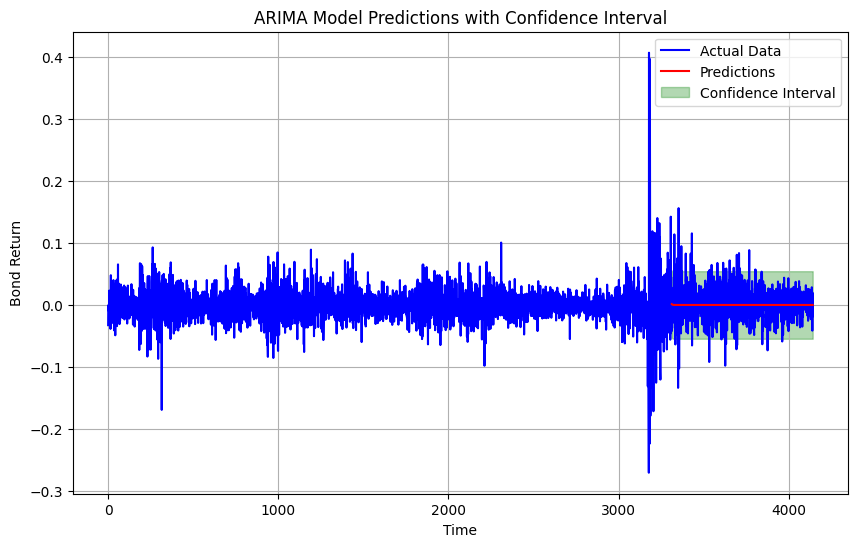

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model on the entire data
model = ARIMA(X, order=(1, 0, 1))  # Fit the model to the entire data
results = model.fit()

# Get forecast and confidence intervals
forecast_steps = len(X) - split_index
forecast = results.get_forecast(steps=forecast_steps)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual data
plt.figure(figsize=(10, 6))
plt.plot(range(len(X)), X, label='Actual Data', color='blue')

# Plot predicted values with confidence intervals
plt.plot(range(split_index, len(X)), preds, label='Predictions', color='red')
plt.fill_between(range(split_index, len(X)), conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.3, label='Confidence Interval')

plt.title('ARIMA Model Predictions with Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Bond Return')
plt.legend()
plt.grid(True)
plt.show()

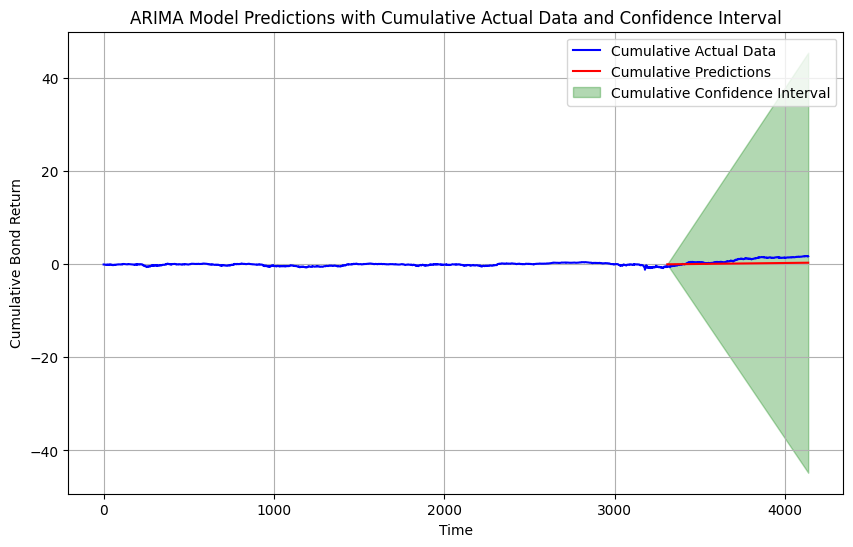

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'X' contains your original data
cumulative_X = np.cumsum(X)  # Calculate cumulative sum of the original data

# Fit the ARIMA model on the entire data
model = ARIMA(X, order=(1, 0, 1))  # Fit the model to the entire data
results = model.fit()

# Get forecast and confidence intervals
forecast_steps = len(X) - split_index
forecast = results.get_forecast(steps=forecast_steps)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot cumulative sum of actual data
plt.figure(figsize=(10, 6))
plt.plot(range(len(X)), cumulative_X, label='Cumulative Actual Data', color='blue')

# Plot predicted values with confidence intervals
plt.plot(range(split_index, len(X)), preds.cumsum(), label='Cumulative Predictions', color='red')
plt.fill_between(range(split_index, len(X)), conf_int[:, 0].cumsum(), conf_int[:, 1].cumsum(), color='green', alpha=0.3, label='Cumulative Confidence Interval')

plt.title('ARIMA Model Predictions with Cumulative Actual Data and Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Cumulative Bond Return')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
df

,date,bond,oil,gold,oil_ret,gold_ret,bond_ret
12001,2008-01-02,3.91,99.64,846.75,0.038458,0.015592,-0.032178
12002,2008-01-03,3.91,99.17,858.85,-0.004717,0.014290,0.000000
12003,2008-01-04,3.88,97.90,855.00,-0.012806,-0.004483,-0.007673
12004,2008-01-07,3.86,95.08,859.25,-0.028805,0.004971,-0.005155
12005,2008-01-08,3.86,96.43,873.50,0.014199,0.016584,0.000000
...,...,...,...,...,...,...,...
16133,2023-11-03,4.57,81.19,1994.45,-0.022278,0.005470,-0.021413
16134,2023-11-06,4.67,81.54,1984.60,0.004311,-0.004939,0.021882
16135,2023-11-07,4.58,77.96,1960.70,-0.043905,-0.012043,-0.019272
16136,2023-11-08,4.49,75.85,1959.35,-0.027065,-0.000689,-0.019651
